In [1]:
##---------------------------------------------------------------------------------
## Summary : Implementing the Skip-Gram model using hierarchical binary sampling
## Author  : Srinivas Venkata Vemparala
## Source  : https://github.com/neubig/nn4nlp-code
##---------------------------------------------------------------------------------

%matplotlib inline
import numpy as np
import pandas as pd
import dynet as dy
import time 
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from sklearn.manifold import TSNE
plt.rcParams["figure.figsize"] = (14,9)

In [2]:
# lets write a method to convert the words to integers
w2i = defaultdict(lambda:len(w2i))

# lets add the words end of sentence(<s>) and unknown(<unk>) to the default dictionary
S = w2i['<s>']
UNK = w2i['<unk>']

# lets write a method to read the data from file
def readDataSet(fileName):
    retList = []
    
    with open(fileName,'r+') as file:
        for line in file:
            words = [w2i[x] for x in line.lower().strip().split(' ')]
            retList.append(words)
    return retList


In [3]:
# lets read the training and testing data. We are using the pen-tree-bank.
# In this the rare words are already replaced by <UNK>

train = readDataSet('../data/ptb/train.txt')
test = readDataSet('../data/ptb/valid.txt')

# lets freeze the dictionary
w2i = defaultdict(lambda:UNK, len(w2i))

# lets write a method to convert the integers back to words.
i2w = {v:k for k,v in w2i.items()}

#compute the number of words in vocabulary.
nWords = len(w2i)
print('Vocabulary size : ', nWords)

# get the binaray representation of the words
nBits = len(np.binary_repr(nWords-1))
print(nBits)

Vocabulary size :  10000
14


In [4]:
# lets declare the size of each embedding,N in N-grams and number of negative samples
nEmb = 32 # each word will have vector of length 32
N = 2     # length of window on each side (so N=2 gives a total window size of 5, as in t-2 t-1 t t+1 t+2)
K = 3     # the number of negative samples.

# Now lets define the model and trainer
model = dy.Model()
trainer = dy.AdamTrainer(model,alpha=0.01)

# lets add the parameters to the model
W_emb = model.add_lookup_parameters((nWords,nEmb))       # lookups for each word vector
W_sm = model.add_parameters((nBits,nEmb))         # binary weights



In [5]:
#lets write a method to compute the loss
def computeLoss(sent):
    # renew the computation graph
    dy.renew_cg()
    
    # get the embeddings for each word of sentence
    emb = [W_emb[x] for x in sent]
    
    # get the W_sm to computation graph
    w_softMax = dy.parameter(W_sm)
    
    # initialize all losses
    allLosses = []
    
    for i,embed in enumerate(emb):
        scores = dy.logistic(w_softMax*embed)   # get the scores in terms of bits
        pos_words = ([sent[x] if x>=0 else S for x in range(i-N,i)]+[sent[x] if x<len(sent) else S for x in range(i+1,i+N+1)])
        
        # convert each posword into bits and add zeros and begining if it doesn't have 14 bits. 
        # then convert each bit to a float value ex: 2 becomes [0.0,0.0,...,1.0,0.0]
        word_repr = [[float(y) for y in np.binary_repr(x).zfill(nBits)] for x in pos_words]
        
        # convert word representation into an input vector
        word_repr = [dy.inputVector(x) for x in word_repr]
        
        # compute the loss 
        allLosses.extend([dy.binary_log_loss(scores,x) for x in word_repr])
    return dy.esum(allLosses)
    

In [6]:
# lets start the training and computing the embedding
trainLosses = []
testLosses = []

print('Started training ....')

for i in range(100):
    # randomly shuffle the training examples
    random.shuffle(train)
    
    trainLoss = 0.0
    startTime = time.time()
    numOfWordsProcessed = 0
    
    for sent in train:
        loss = computeLoss(sent)
        trainLoss = trainLoss+loss.value()
        
        numOfWordsProcessed = numOfWordsProcessed + len(sent)
        
        # do backward pass to compute the gradients and update parameters
        loss.backward()
        trainer.update()
    trainLosses.append(trainLoss)
    print('Iteration ',i,' : ',' TrainingLoss : ',(trainLoss/numOfWordsProcessed),' Number of words processed : ',numOfWordsProcessed,' Time taken : ',
         (time.time()-startTime))
    
    testLoss = 0.0
    for sent in test:
        loss = computeLoss(sent)
        testLoss = testLoss+loss.value()
    testLosses.append(testLoss)
    print('Iteration ',i,' : ',' TestLoss : ',(testLoss/numOfWordsProcessed))

Started training ....
Iteration  0  :   TrainingLoss :  31.117018750599474  Number of words processed :  887521  Time taken :  47.17254328727722
Iteration  0  :   TestLoss :  2.4351439135691137
Iteration  1  :   TrainingLoss :  30.688777254266594  Number of words processed :  887521  Time taken :  50.31207275390625
Iteration  1  :   TestLoss :  2.431105849421122
Iteration  2  :   TrainingLoss :  30.632669956172705  Number of words processed :  887521  Time taken :  47.77371692657471
Iteration  2  :   TestLoss :  2.4277431011144612
Iteration  3  :   TrainingLoss :  30.604478608968492  Number of words processed :  887521  Time taken :  47.17611837387085
Iteration  3  :   TestLoss :  2.434767168278457
Iteration  4  :   TrainingLoss :  30.586585815478614  Number of words processed :  887521  Time taken :  45.97066640853882
Iteration  4  :   TestLoss :  2.4259823548541557
Iteration  5  :   TrainingLoss :  30.574729795492715  Number of words processed :  887521  Time taken :  45.516475915908

Iteration  94  :   TrainingLoss :  30.516861723112587  Number of words processed :  887521  Time taken :  44.44239640235901
Iteration  94  :   TestLoss :  2.4269033042093824
Iteration  95  :   TrainingLoss :  30.516416218389573  Number of words processed :  887521  Time taken :  45.82204842567444
Iteration  95  :   TestLoss :  2.4279039514884513
Iteration  96  :   TrainingLoss :  30.516430283958233  Number of words processed :  887521  Time taken :  44.388593673706055
Iteration  96  :   TestLoss :  2.428546842164209
Iteration  97  :   TrainingLoss :  30.516259111575113  Number of words processed :  887521  Time taken :  44.191489458084106
Iteration  97  :   TestLoss :  2.427749211034704
Iteration  98  :   TrainingLoss :  30.51685239517603  Number of words processed :  887521  Time taken :  47.694865226745605
Iteration  98  :   TestLoss :  2.4292413504890713
Iteration  99  :   TrainingLoss :  30.51667400620914  Number of words processed :  887521  Time taken :  49.74846315383911
Iterati

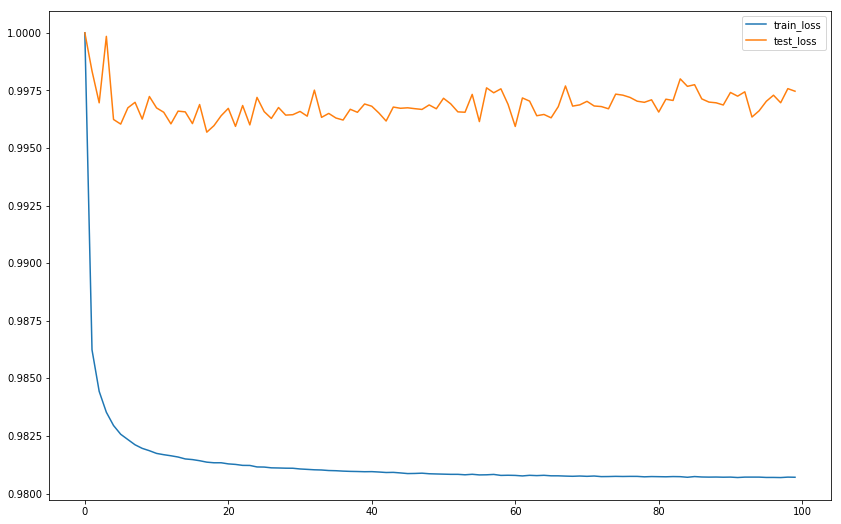

In [7]:
# normalize the training loss and test loss by dividing with initial element
trainLoss0 = trainLosses[0]
trainLosses = [(x/trainLoss0) for x in trainLosses]
    
testLoss0 = testLosses[0]
testLosses = [(x/testLoss0) for x in testLosses]
    
train_loss, = plt.plot(trainLosses,label='train_loss')
test_loss, = plt.plot(testLosses,label='test_loss')
plt.legend(handles=[train_loss,test_loss])
plt.show()

In [9]:
# lets write the input and output embeddings to file
inputEmbeddings = 'inputEmbeddingsSkipGram_binary.txt'
outputEmbeddings = 'outputEmbeddingsSkipGram_binary.txt'
labels = 'labelsSkipGram_binary.txt'

with open(inputEmbeddings,'w') as f:
    embeddings = W_emb.as_array()
    for i in range(nWords):
        f.write('\t'.join(map(str,embeddings[i])) + '\n')

        
with open(labels,'w') as f:
    for i in range(nWords):
        f.write(i2w[i] + '\n')   

In [11]:
# read the data from the file
dfEmbeddings = pd.read_csv('inputEmbeddingsSkipGram_binary.txt',header=None,sep='\t')

# convert the data frame to matrix
embeddings = dfEmbeddings.as_matrix()
X_embedded = TSNE(n_components=2).fit_transform(embeddings[:150])

# read the labels
dfLabels = pd.read_csv('labelsSkipGram_binary.txt',header=None,sep='\n')
labels = dfLabels[0].as_matrix()

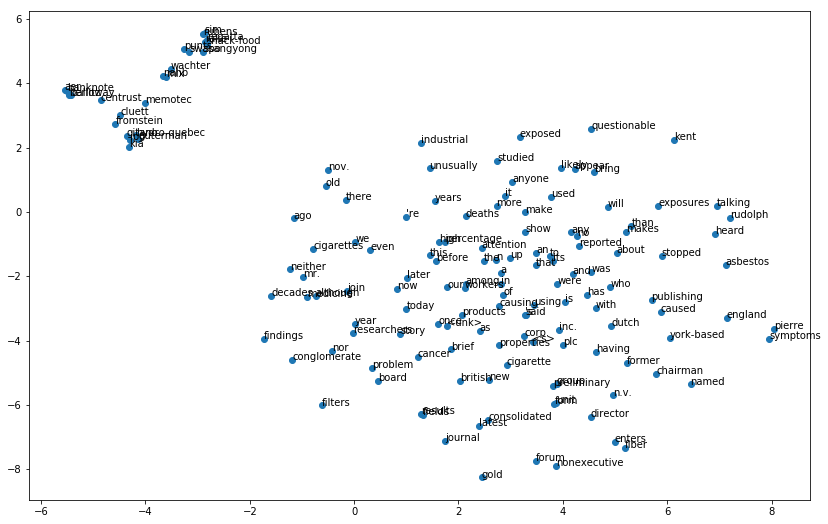

In [12]:
x = X_embedded[:,0]
y = X_embedded[:,1]
z = labels[:150]

# lets plot the data
fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(z):
    ax.annotate(txt, (x[i],y[i]))